考察各系数在湿法烟气脱硫FGD过程数据上对变量与目标间关联的识别能力

In [8]:
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import random
import sys
import os

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../" * 2))
sys.path.insert(0, BASE_DIR)

from setting import plt, PROJ_CMAP
from giefstat.estimate import cal_assoc
from giefstat.util import UnsuperCategorEncoding

METHODS = ["PearsonCorr", "SpearmanCorr", "DistCorr", "MI-cut", "MI-qcut", "MI-GIEF", "MIC", "RMIC"]

In [9]:
def cal_assoc_new(x, y, method):
    assert method in METHODS
    if method == "MI-GIEF":
        return cal_assoc(x, y, method="MI-GIEF", k=3, xtype="c", ytype="c")
    else:
        return cal_assoc(x, y, method=method)

载入数据并可视化：

In [10]:
X_df = pd.read_csv("data/X_df.csv")
Y_df = pd.read_csv("data/Y_df.csv")

# 重新随机编码, 取最差的情况好区分MIC和RMIC效果
X = X_df.values
X_df["motor_onoff_states"] = UnsuperCategorEncoding(X[:, 0]).random_encoding(seed=5)
X, Y = X_df.values, Y_df.values

<Figure size 288x144 with 0 Axes>

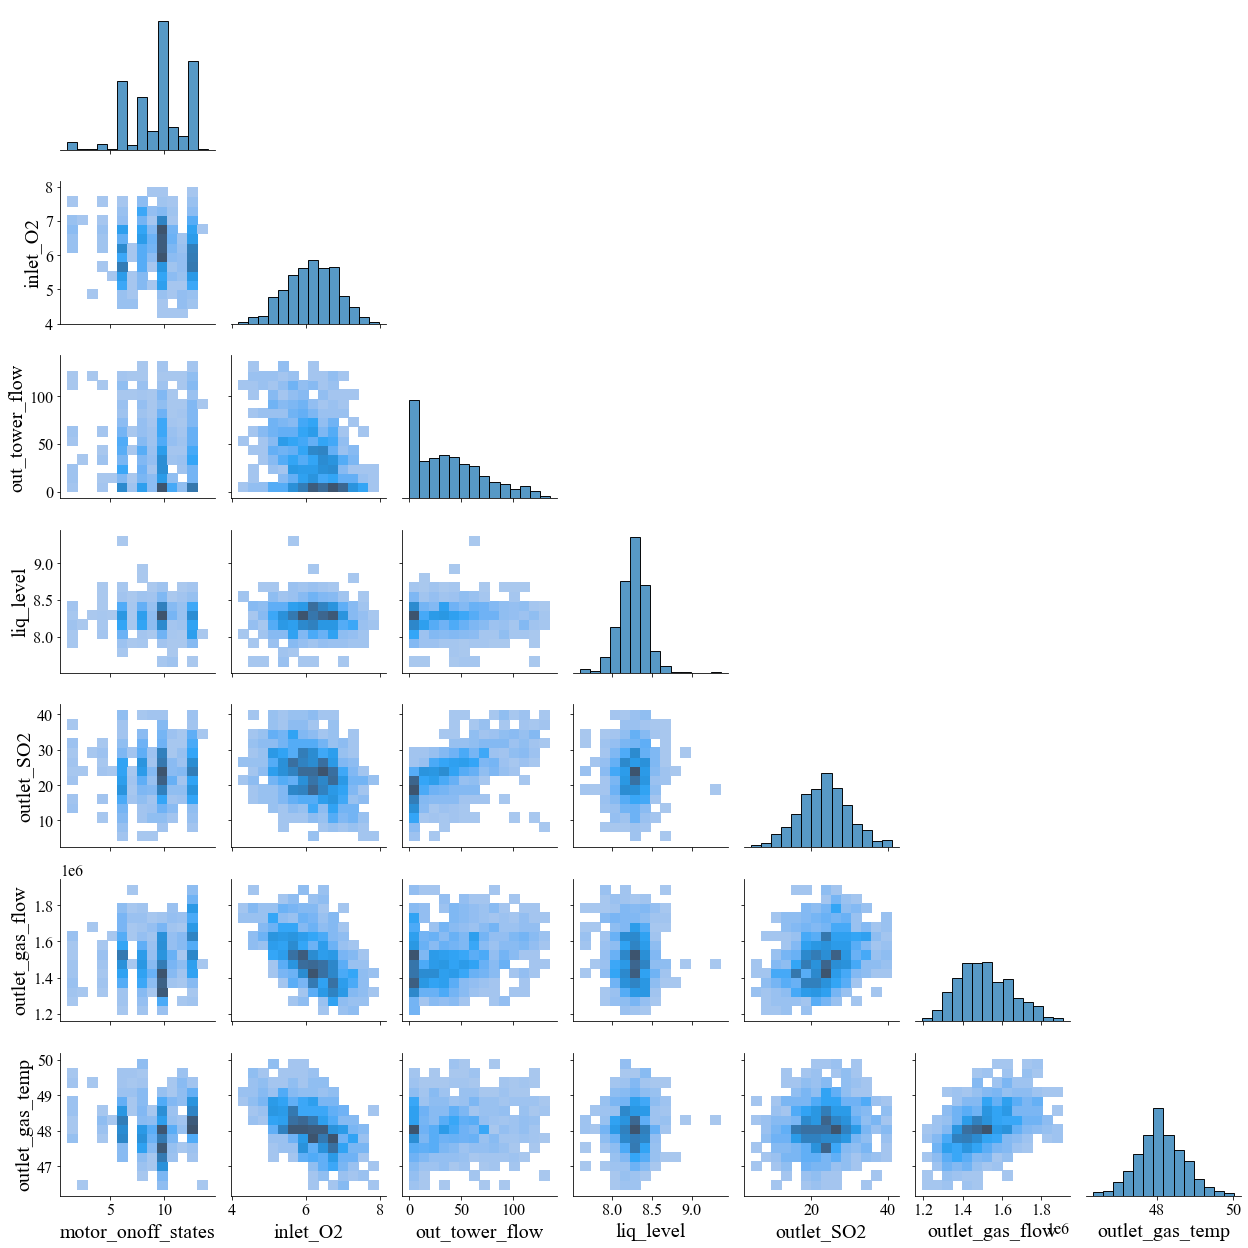

In [11]:
plt.figure(figsize=(4, 2))
df = pd.concat([X_df, Y_df], axis=1)
with sns.plotting_context(rc={"axes.labelsize": 20, "xtick.labelsize":16, "ytick.labelsize":16}):
    sns.pairplot(df, kind="hist", corner=True, plot_kws={"bins": 14}, diag_kws={"bins": 14})
plt.tight_layout()

记录每个系数基于代用数据的检测结果并画图：

0.08 (0.05),0.08 (0.07),0.17 (0.14),0.65 (0.62),1.29 (1.29),0.01 (-0.01),0.22 (0.20),0.00 (-0.02),
0.21 (0.05),0.22 (0.06),0.30 (0.13),0.77 (0.65),1.35 (1.29),0.13 (-0.01),0.23 (0.21),0.06 (-0.03),
0.06 (0.06),0.10 (0.06),0.27 (0.14),0.78 (0.64),1.38 (1.29),0.17 (-0.01),0.25 (0.21),0.10 (-0.02),
0.34 (0.06),0.33 (0.07),0.35 (0.15),0.99 (0.97),1.33 (1.30),0.06 (-0.01),0.29 (0.23),0.09 (-0.01),
0.55 (0.05),0.55 (0.07),0.55 (0.15),1.11 (0.99),1.43 (1.30),0.20 (-0.01),0.41 (0.24),0.23 (-0.02),
0.54 (0.09),0.54 (0.07),0.52 (0.15),1.07 (0.95),1.41 (1.29),0.19 (-0.01),0.38 (0.22),0.19 (-0.02),
0.67 (0.05),0.68 (0.05),0.69 (0.14),1.23 (0.96),1.53 (1.28),0.38 (0.01),0.53 (0.24),0.38 (-0.00),
0.26 (0.09),0.27 (0.05),0.30 (0.16),1.03 (0.99),1.33 (1.28),0.06 (0.01),0.27 (0.22),0.04 (-0.02),
0.10 (0.08),0.10 (0.06),0.18 (0.15),0.93 (0.92),1.30 (1.30),-0.00 (0.01),0.23 (0.22),-0.01 (-0.02),
0.06 (0.08),0.05 (0.06),0.15 (0.17),0.80 (0.81),1.29 (1.30),-0.00 (-0.01),0.23 (0.22),-0.02 (-0.02),
0.12 (0.0

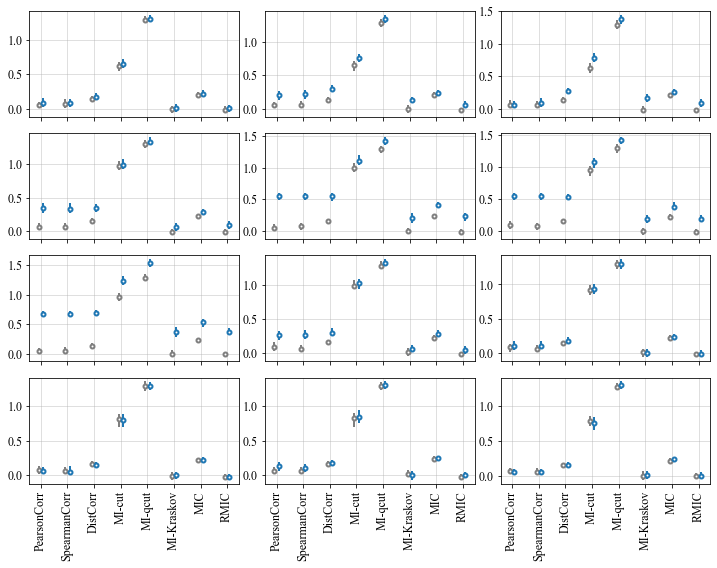

In [12]:
rounds = 100
sub_sample_size = 120
h = 0.08  # 用于调整画图位置

plt.figure(figsize=(10, 8))
for i, j in itertools.product(range(4), range(3)):
    x, y = X[:, i], Y[:, j]
    N = len(x)

    print_content = ""
    for m, method in enumerate(METHODS):
        
        # 关联系数分布
        assocs = []
        for _ in range(rounds):
            _idxs = random.sample(range(N), sub_sample_size)
            x_, y_ = x[_idxs], y[_idxs]
            assocs.append(cal_assoc_new(x_, y_, method))

        x_srg = np.random.choice(x, N, replace=False)
        assocs_srg = []
        for _ in range(rounds):
            _idxs = random.sample(range(N), sub_sample_size)
            x_, y_ = x_srg[_idxs], y[_idxs]
            assocs_srg.append(cal_assoc_new(x_, y_, method))

        # 画图
        q1, med, q3 = np.quantile(assocs, (0.25, 0.5, 0.75))
        q1s, meds, q3s = np.quantile(assocs_srg, (0.25, 0.5, 0.75))

        if method == "RMIC":
            a = meds + np.random.random() * 0.03
            q1 -= a
            q3 -= a
            med -= a
            q1s -= a
            q3s -= a
            meds -= a

        print_content += "%.2f (%.2f)," % (med, meds)

        plt.subplot(4, 3, i * 3 + j + 1)
        plt.scatter(m - h, meds, c="w", s=16, edgecolor=PROJ_CMAP["grey"], linewidth=2, zorder=5)
        plt.plot([m - h, m - h], [q1s, q3s], c=PROJ_CMAP["grey"], linewidth=2)
        plt.scatter(m + h, med, c="w", s=16, edgecolor=PROJ_CMAP["blue"], linewidth=2, zorder=5)
        plt.plot([m + h, m + h], [q1, q3], c=PROJ_CMAP["blue"], linewidth=2)
                # plt.ylim([-0.1, 1.1])

    print(print_content)

    methods = METHODS.copy()
    for k, p in enumerate(methods):
        methods[k] = p if p != "MI-GIEF" else "MI-Kraskov"
    # methods = [p for p in METHODS if p != "MI-GIEF" else "MI-Kraskov"]

    if i == 3:
        plt.xticks(range(len(methods)), methods, rotation=90)
    else:
        plt.xticks(range(len(methods)), [])

    plt.grid(True, alpha=0.5)
plt.tight_layout()